# Playing Cards Classification - EfficientNet - Timm

### Necessary imports

In [3]:
import numpy as np

import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import timm

from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm

### Dataset

In [13]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [14]:
transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [15]:
data_dir = 'data/train/'
data = PlayingCardDataset(data_dir, transform=transforms)
len(data)

7624

### Dataloader

In [47]:
dataloader = DataLoader(data, batch_size=32, shuffle=True)

### Pytorch Model

In [26]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        # Define the components of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children()))[:-1]

        feature_size = 1280

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_size, num_classes)
        )

    def forward(self, x):
        # Connect the components of the model
        x = self.features(x)
        x = self.classifier(x)

        return x

### Training loop

In [21]:
model = SimpleCardClassifier()

In [27]:
train_folder = 'data/train'
test_folder = 'data/test'
valid_folder = 'data/valid'

train_dataset = PlayingCardDataset(train_folder, transform=transforms)
test_dataset = PlayingCardDataset(test_folder, transform=transforms)
valid_dataset = PlayingCardDataset(valid_folder, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [34]:
num_epochs = 5
training_losses = []
valid_losses = []

In [36]:
model = SimpleCardClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    training_loss = running_loss/len(train_loader.dataset)
    training_losses.append(training_loss)

    # Model Evaluation Phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * input.size(0)

    valid_loss = running_loss / len(valid_loader.dataset)
    valid_losses.append(valid_loss)
            
    print(f"Epoch: {epoch+1}/{num_epochs} - Train loss: {training_loss} - Validation loss: {valid_loss}")


100%|██████████| 239/239 [07:06<00:00,  1.78s/it]


Epoch: 1/5 - Train loss: 1.615008421484596 - Validation loss: 0.5463390134415537


100%|██████████| 239/239 [07:04<00:00,  1.78s/it]


Epoch: 2/5 - Train loss: 0.578870512599835 - Validation loss: 0.2612291630708946


100%|██████████| 239/239 [07:03<00:00,  1.77s/it]


Epoch: 3/5 - Train loss: 0.35547875218163755 - Validation loss: 0.32194030059958406


100%|██████████| 239/239 [06:22<00:00,  1.60s/it]


Epoch: 4/5 - Train loss: 0.26288167919654787 - Validation loss: 0.1813374435001949


100%|██████████| 239/239 [06:34<00:00,  1.65s/it]


Epoch: 5/5 - Train loss: 0.19031031831614242 - Validation loss: 0.10249558316086824


### Visualizing Predictions

In [40]:
# For inference
def preprocess_image(image_path, transform):
    image = Image.open(image_path)
    print(type(image))
    rgb_image = image.convert('RGB')
    return rgb_image, transform(rgb_image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display the image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions\
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_ylabel("Class Name")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

<class 'PIL.JpegImagePlugin.JpegImageFile'>


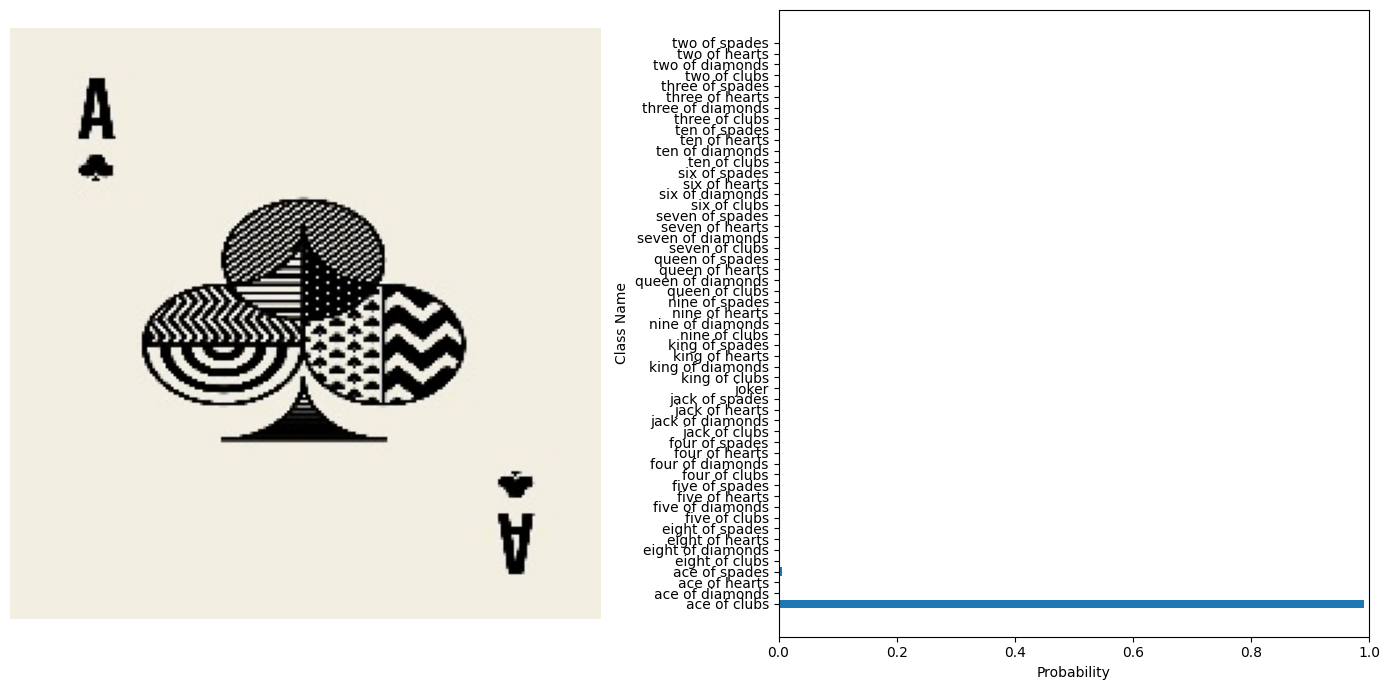

In [44]:
test_image = 'data/valid/ace of clubs/1.jpg'
original_image, image_tensor = preprocess_image(test_image, transforms)

probabilities = predict(model, image_tensor, device)
class_names = data.classes

visualize_predictions(original_image, probabilities, class_names)

### Saving the model

In [ ]:
torch.save(model.state_dict(), 'saved_models/model.pth')